In [22]:
from climpred.prediction import _pseudo_ens
from climpred.relative_entropy import (compute_relative_entropy, _gen_control_ensemble,
                                       bootstrap_relative_entropy, plot_relative_entropy)
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof

# Intro

Relative is a measure of potential predictability based on information theory where the signal and spread components of predictability are measured on the same scale.

---

References:
- Theory:
  - Kleeman, Richard. “Measuring Dynamical Prediction Utility Using Relative Entropy.” Journal of the Atmospheric Sciences 59, no. 13 (July 1, 2002): 2057–72. https://doi.org/10/fqwxpk.
  - DelSole, Timothy. “Predictability and Information Theory. Part I: Measures of Predictability.” Journal of the Atmospheric Sciences 61, no. 20 (October 1, 2004): 2425–40. https://doi.org/10/cttkfw.
  - DelSole, Timothy, and Michael K. Tippett. “Predictability in a Changing Climate.” Climate Dynamics 51, no. 1 (July 1, 2018): 531–45. https://doi.org/10/gdr3j7.
  - Majda, Andrew, Richard Kleeman, and David Cai. “A Mathematical Framework for Quantifying Predictability Through Relative Entropy.” Methods and Applications of Analysis 9, no. 3 (September 2002): 425–44. https://projecteuclid.org/euclid.maa/1119027733.


- Application:
  - Branstator, Grant, and Haiyan Teng. “Potential Impact of Initialization on Decadal Predictions as Assessed for CMIP5 Models.” Geophysical Research Letters 39, no. 12 (June 23, 2012). https://doi.org/10/gbpvf7.
  - ———. “Two Limits of Initial-Value Decadal Predictability in a CGCM.” Journal of Climate 23, no. 23 (August 27, 2010): 6292–6311. https://doi.org/10/bwq92h.
  - Branstator, Grant, Haiyan Teng, Gerald A. Meehl, Masahide Kimoto, Jeff R. Knight, Mojib Latif, and A. Rosati. “Systematic Estimates of Initial-Value Decadal Predictability for Six AOGCMs.” Journal of Climate 25, no. 6 (September 9, 2011): 1827–46. https://doi.org/10/d3cmjw.
  - Teng, Haiyan, and Grant Branstator. “Initial-Value Predictability of Prominent Modes of North Pacific Subsurface Temperature in a CGCM.” Climate Dynamics 36, no. 9 (May 1, 2011): 1813–34. https://doi.org/10/b9vdgh.


---

Needed to run this script:
- from a given region:
 - ds (xr.DataArray): ensemble data with dimensions ensemble, member, time, lon (x), lat(y)
 - control (xr.DataArray): control data with dimensions time, lon (x), lat(y)
Output: 
- relative entropy per ensemble initialization and lead year of that region

# Load data

## Load Masking file

In [2]:
file_origin = '/work/mh0727/m300524/'
file_origin = '/Users/aaron.spring/mistral_work/'
results = file_origin + 'experiments/tmp/'

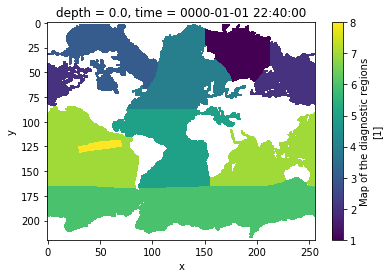

In [3]:
rbek = xr.open_dataset(
    file_origin + 'experiments/masks/GR15_rbek.nc').squeeze()['rbek']
rbek.plot(yincrease=False)

## Load control and ds

In [4]:
curv=True
control = xr.open_dataset(
    results + 'control3d_tos.nc')['tos'].rename({'year': 'time'}).squeeze()
control['time'] = np.arange(3000, 3000 + control.time.size)

In [5]:
ds = xr.open_dataset(
    results + 'ds_tos.nc')['tos'].rename({'year': 'time'}).squeeze()
ds['time'] = np.arange(1, 1 + ds.time.size)

## Subselect a region

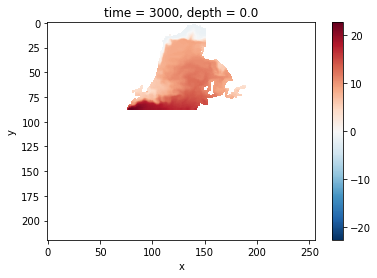

In [6]:
choosen_region = 4
control.where(rbek == choosen_region).isel(time=0).plot(yincrease=False)

In [7]:
control = control.where(rbek == choosen_region)
ds = ds.where(rbek == choosen_region) 

### How much variance is explained by neofs?
Calculate Relative Entropy is limited to the number of EOFs used (neofs) to the number of members available per ensemble initialization - 1.

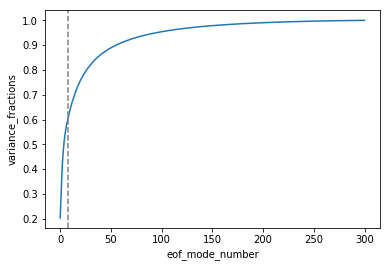

In [8]:
neofs = ds.member.size - 1
solver = Eof(control, weights=None)
solver.varianceFraction().cumsum().plot()
plt.axvline(x=neofs, ls='--', c='gray')

# Relative Entropy calculation

## Generate control distribution P_c

In [12]:
control_ensemble = _gen_control_ensemble(ds, control)

control_ensemble 5109.3504 MB member 90


## Calculate relative entropy

In [14]:
rel_ent = compute_relative_entropy(
    ds, control, control_ensemble, neofs=neofs, ntime=20)

/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/climpred-0.2-py3.6.egg/climpred/relative_entropy.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Bootstrap threshold from uninitialized ensembles
Here I relaxed the significance to 50 = median, because nothing would remain if I take 95%. Branstator and Teng just take an empirical threshold.

In [21]:
rel_ent_threshold = bootstrap_relative_entropy(
    ds, control, control_ensemble, neofs=neofs, sig=50, bootstrap=30)

## Plot results

Text(0.5, 0.98, 'Relative Entropy PM North Atlantic SST')

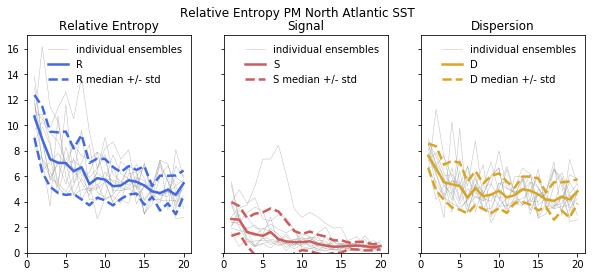

In [20]:
plot_relative_entropy(rel_ent, rel_ent_threshold=None,
             figsize=(10, 4), sharey=True)
plt.suptitle('Relative Entropy PM North Atlantic SST')
# plt.savefig('Relative_Entropy_PM_NA_SST')